In [1]:
import sys
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from numba import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from src import runner_
from src.datasets.utils import load_newsgroups
from src.ml.utils import reduce_dimensions_sparse
from src.plotting.utils import visualize_scores, print_results, visualize_classes, visualize_confusion_matrices
from src.problemgenerator.array import Array
from src.problemgenerator.copy import Copy
from src.problemgenerator.filters import MissingArea
from src.problemgenerator.radius_generators import GaussianRadiusGenerator

In [2]:
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

In [3]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words="english")
        vectorized_train_data = vectorizer.fit_transform(train_data)
        vectorized_test_data = vectorizer.transform(test_data)

        reduced_test_data = reduce_dimensions_sparse(vectorized_test_data, self.random_state)

        fitted_model = self.get_fitted_model(vectorized_train_data, train_labels, params)

        predicted_test_labels = fitted_model.predict(vectorized_test_data)
        cm = confusion_matrix(test_labels, predicted_test_labels)

        return {
            "confusion_matrix": cm,
            "predicted_test_labels": predicted_test_labels,
            "reduced_test_data": reduced_test_data,
            "test_mean_accuracy": round(np.mean(predicted_test_labels == test_labels), 3),
            "train_mean_accuracy": fitted_model.score(vectorized_train_data, train_labels),
        }

In [4]:
class MultinomialNBModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return MultinomialNB(params["alpha"]).fit(train_data, train_labels)


In [5]:
class LinearSVCModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return LinearSVC(C=params["C"], random_state=self.random_state).fit(train_data, train_labels)


In [6]:
class ErrGen:
    def __init__(self):
        self.random_state = RandomState(42)

    def generate_error(self, data, params):
        data = np.array(data)

        data_node = Array(data.shape)
        root_node = Copy(data_node)

        f = MissingArea(params["p"], params["radius_generator"], params["missing_value"])
        data_node.addfilter(f)

        return root_node.process(data, self.random_state)


In [7]:
def visualize(df, dataset_name, label_names, test_data):
    visualize_scores(df, ["test_mean_accuracy", "train_mean_accuracy"], "p",
                     f"{dataset_name} classification scores with added missing areas")
    visualize_classes(df, label_names, "p", "reduced_test_data", "test_labels",
                      f"{dataset_name} (n={len(test_data)}) classes with added missing areas")
    visualize_confusion_matrices(df, label_names, "test_mean_accuracy", "p")
    plt.show()

In [8]:
def main(argv):
    data, labels, labels_name, dataset_name = None, None, None, None
    if len(argv) == 3 and argv[1] in ["all", "test"]:
        data, labels, label_names, dataset_name = load_newsgroups(argv[1], int(argv[2]))
    else:
        exit(0)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2,
                                                                        random_state=RandomState(42))

    p_steps = np.linspace(0, .28, num=8)
    err_params_list = [{
        "p": p,
        "radius_generator": GaussianRadiusGenerator(0, 1),
        "missing_value": " "
    } for p in p_steps]

    alpha_steps = [10 ** i for i in range(-2, 1)]
    C_steps = [10 ** k for k in range(-2, 1)]
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    model_params_dict_list = [
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": False
        },
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": True
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": False
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": True
        },
    ]

    df = runner_.run(train_data, test_data, ErrGen, err_params_list, model_params_dict_list)

    print_results(df, ["train_labels", "test_labels", "reduced_test_data", "confusion_matrix", "predicted_test_labels",
                       "radius_generator", "missing_value"])
    visualize(df, dataset_name, label_names, test_data)

100%|██████████| 8/8 [00:47<00:00,  4.94s/it]


LinearSVC
       C     p  test_mean_accuracy  time_used_err  time_used_mod  train_mean_accuracy
0   0.01  0.00               0.640       0.208610       1.200797             0.550439
1   0.10  0.00               0.754       0.208610       1.194441             0.960526
2   1.00  0.00               0.719       0.208610       1.468901             0.989035
3   0.01  0.04               0.640       2.140410       1.151010             0.539474
4   0.10  0.04               0.728       2.140410       1.175249             0.975877
5   1.00  0.04               0.711       2.140410       1.269897             0.989035
6   0.01  0.08               0.640       3.229913       1.526289             0.541667
7   0.10  0.08               0.702       3.229913       1.441798             0.958333
8   1.00  0.08               0.658       3.229913       1.396515             0.989035
9   0.01  0.12               0.640       4.521924       1.343748             0.539474
10  0.10  0.12               0.684       4.5

/home/local/jpssilve/Data_problems_emulator/dataproblemsemulator/src/plotting/utils.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 8))


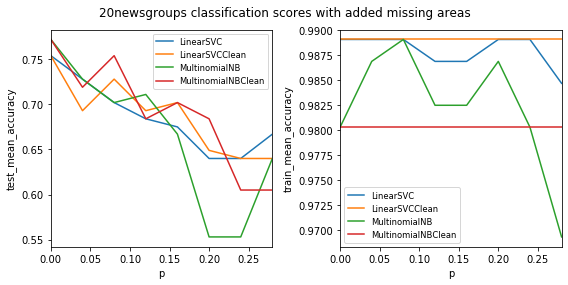

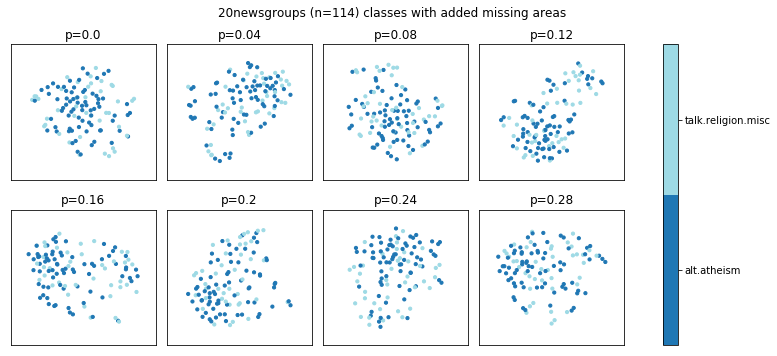

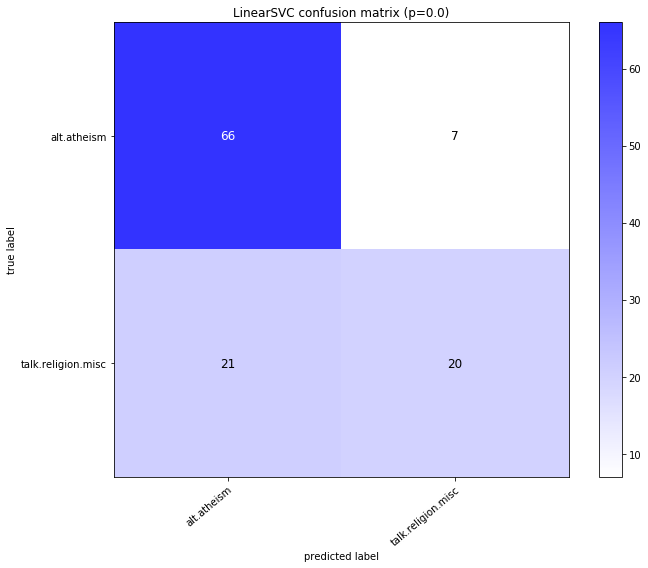

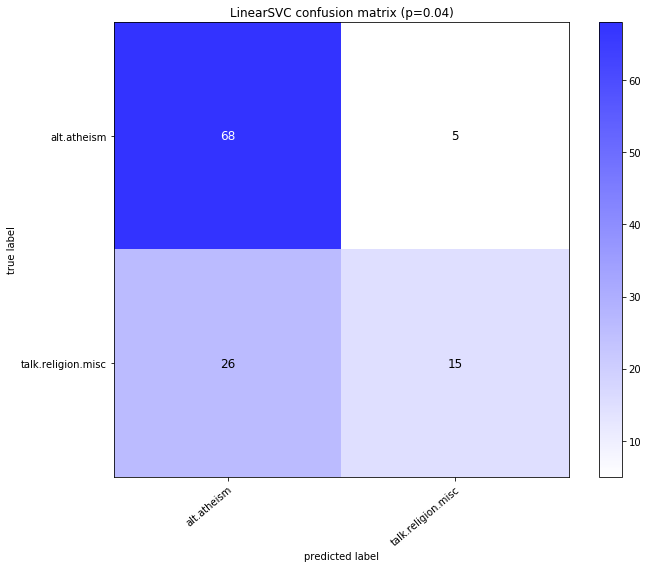

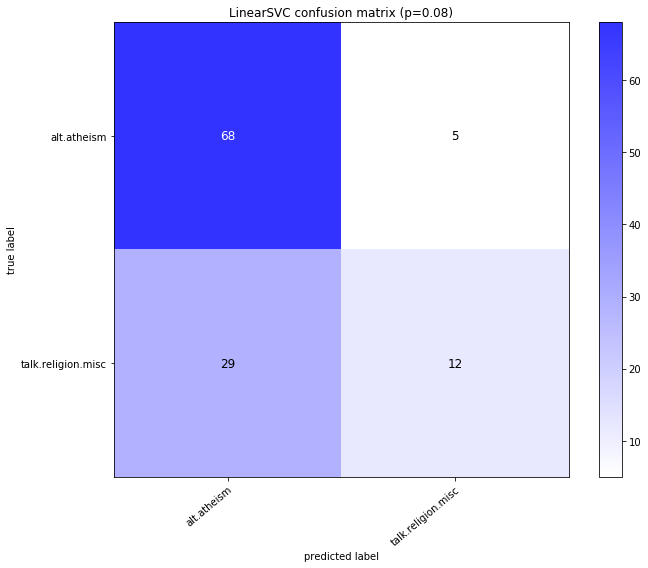

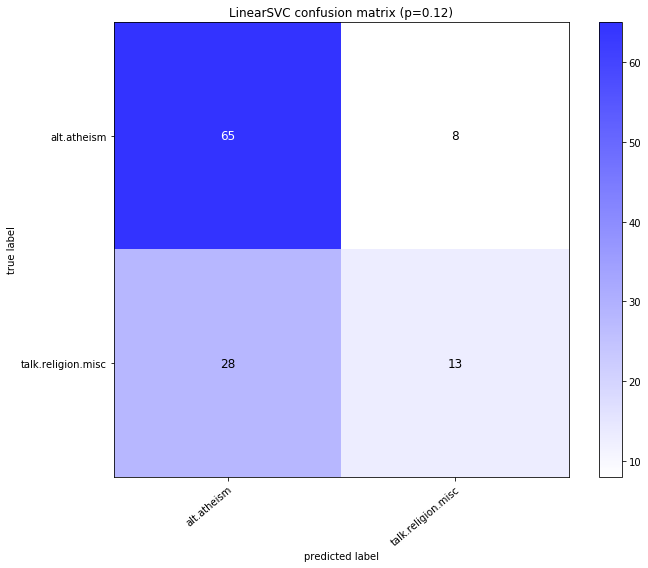

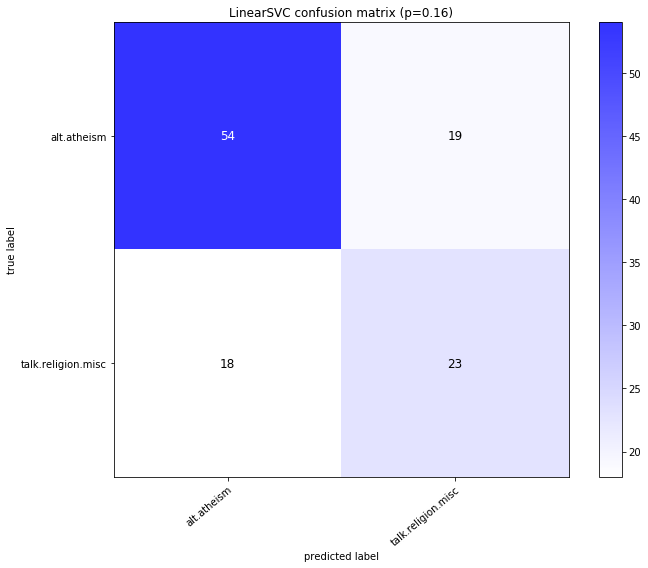

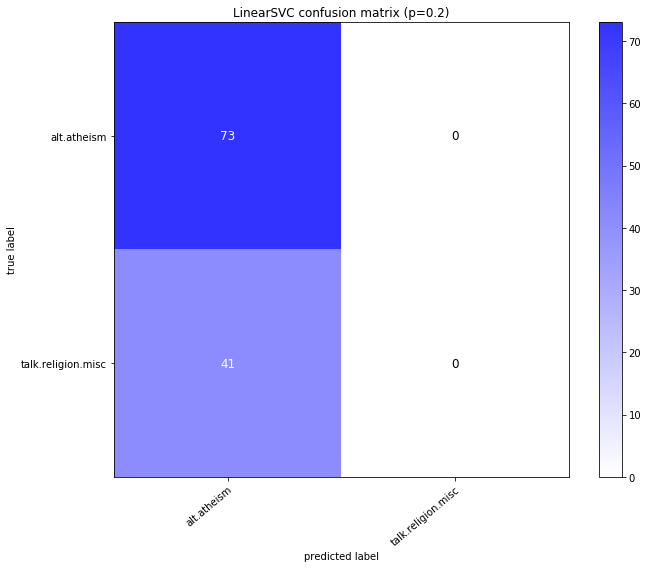

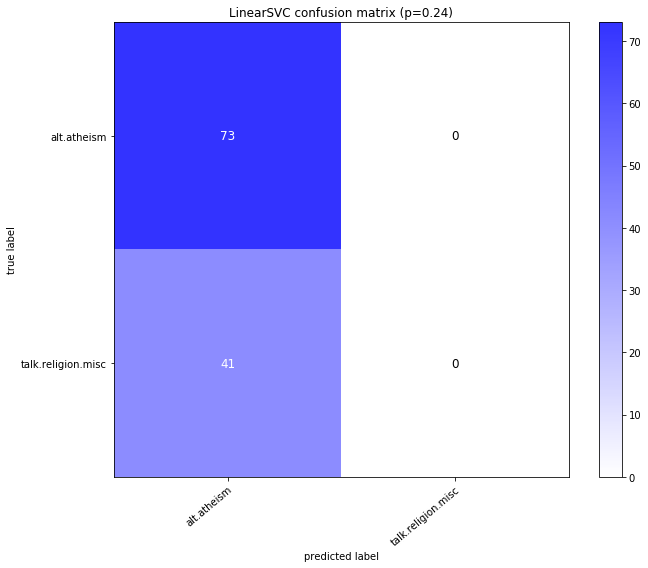

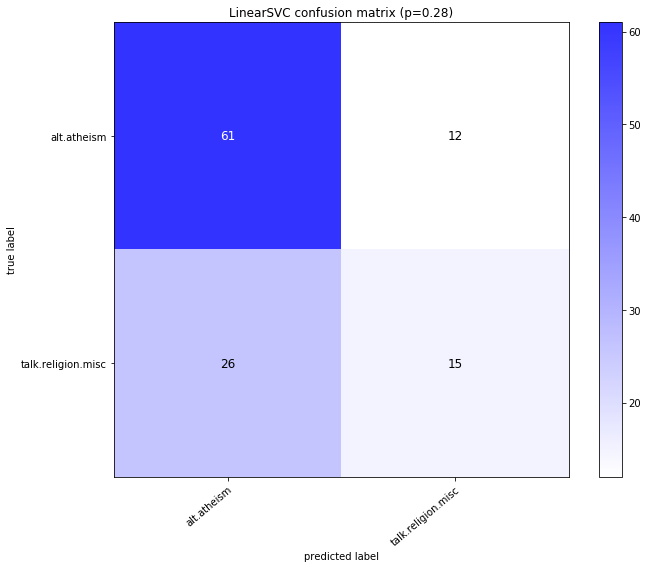

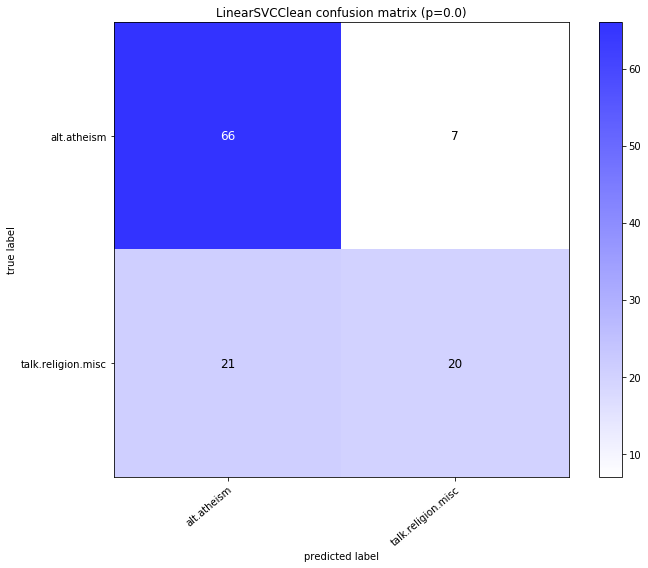

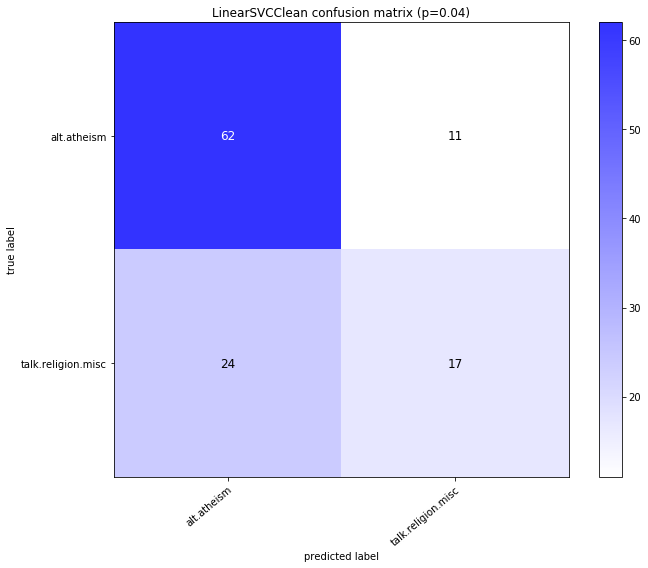

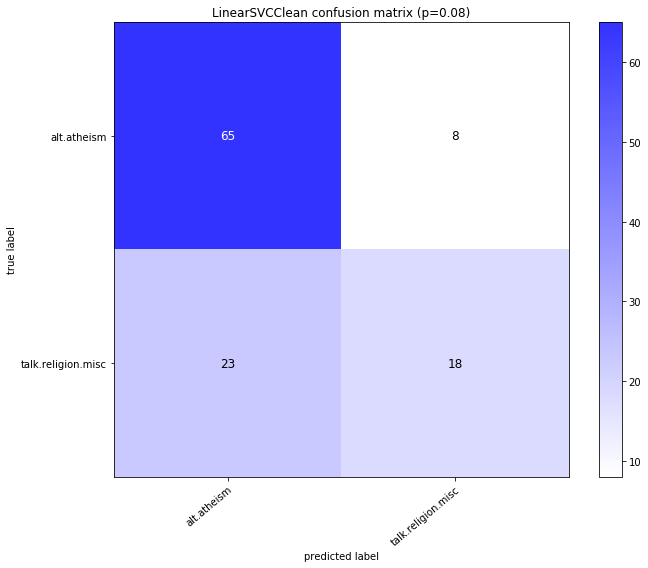

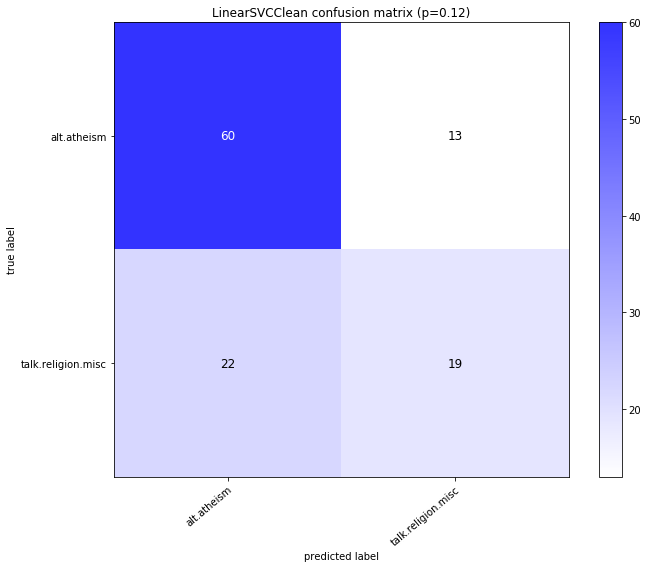

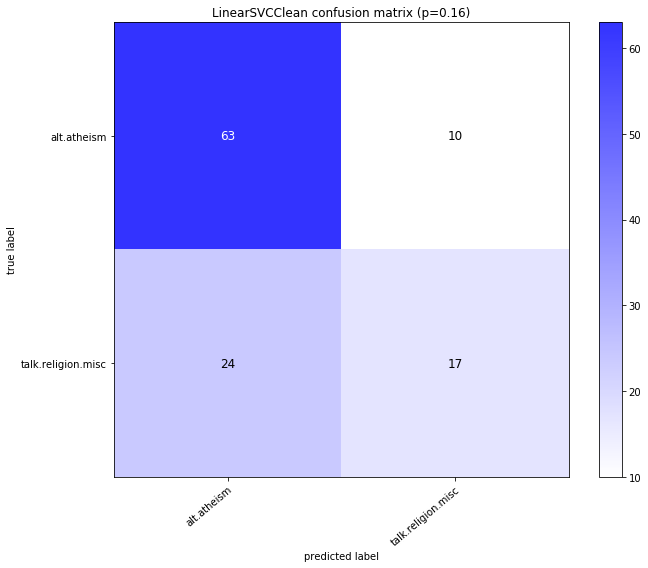

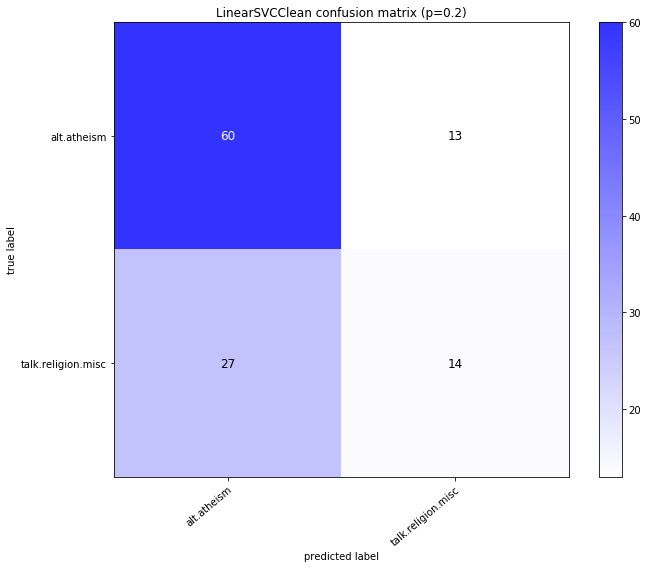

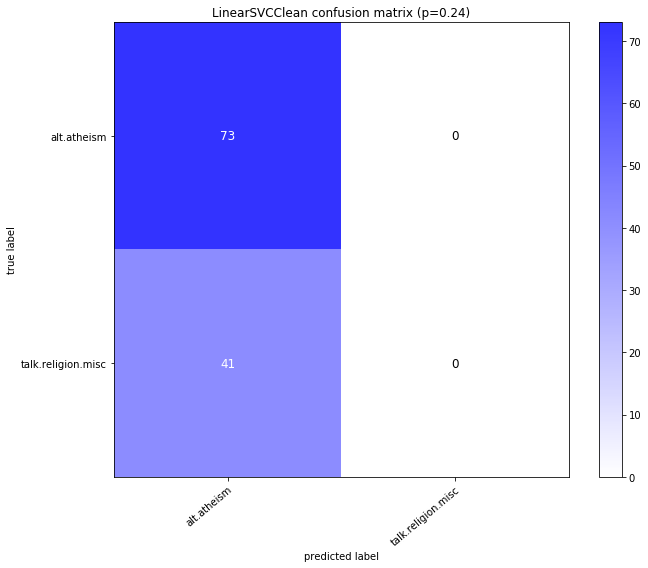

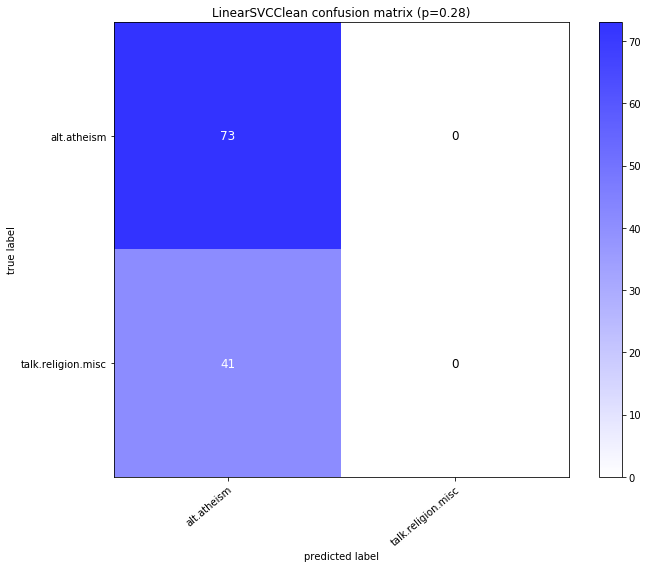

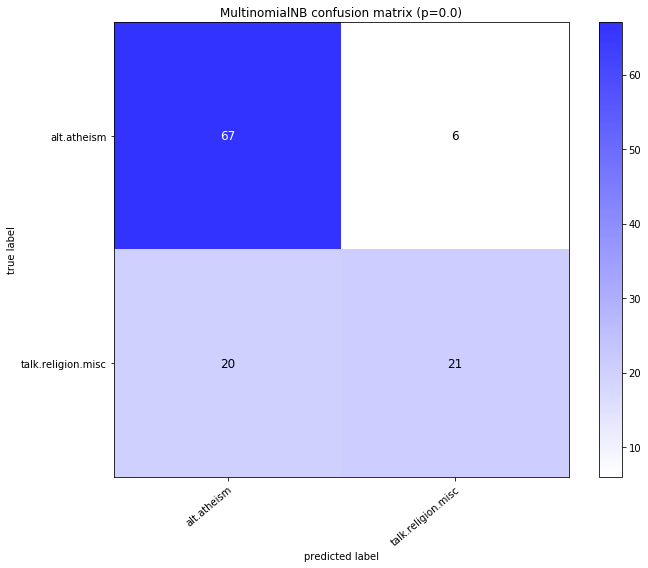

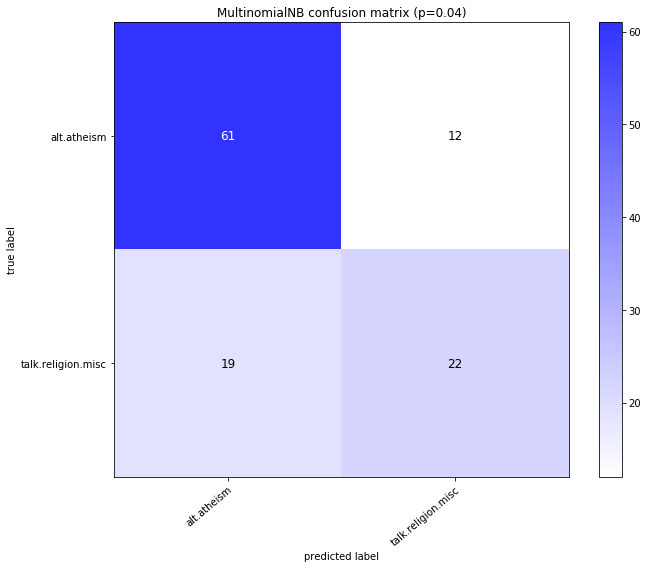

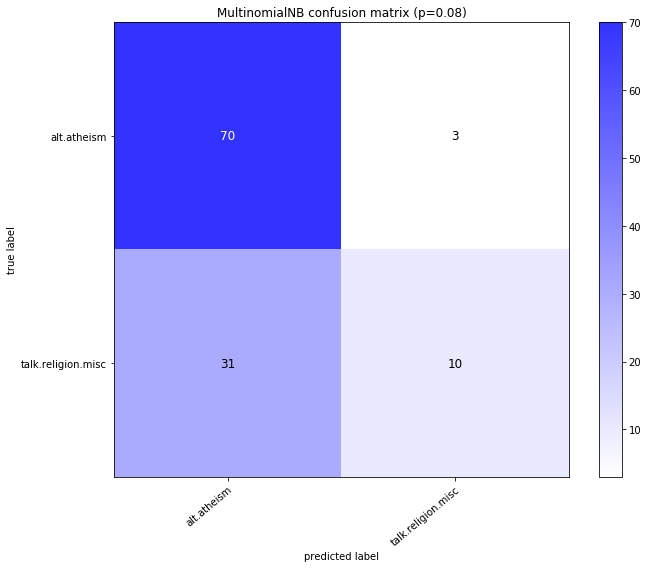

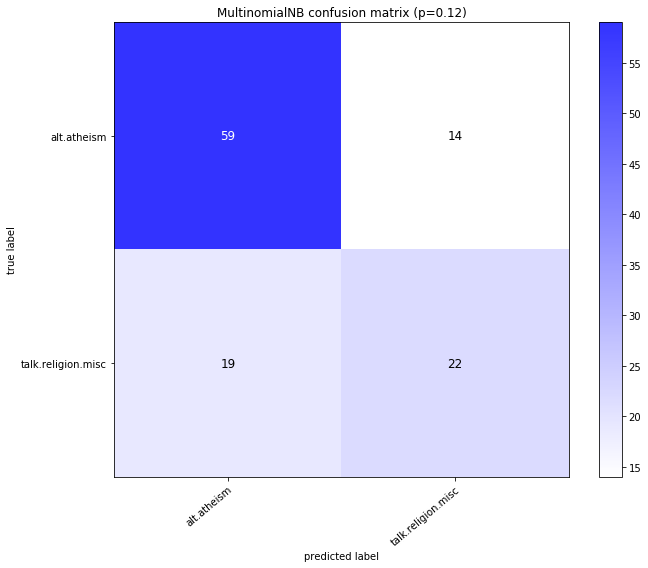

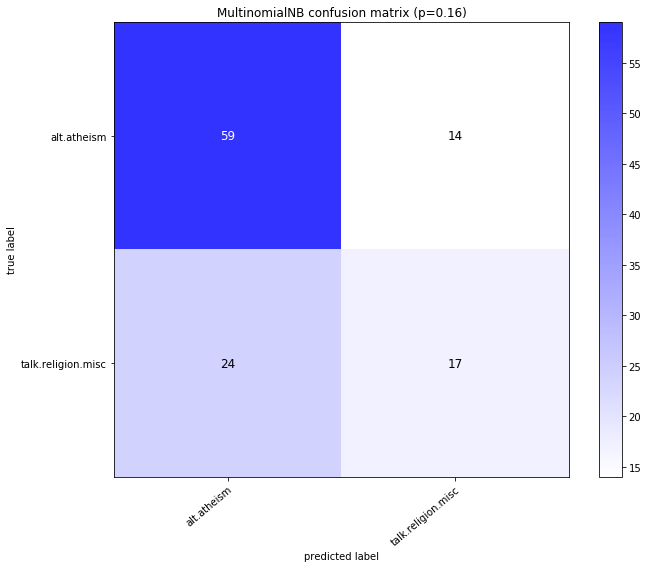

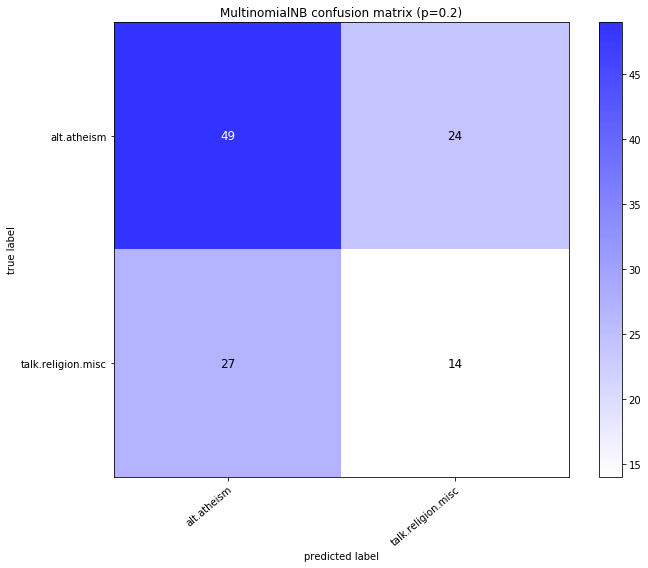

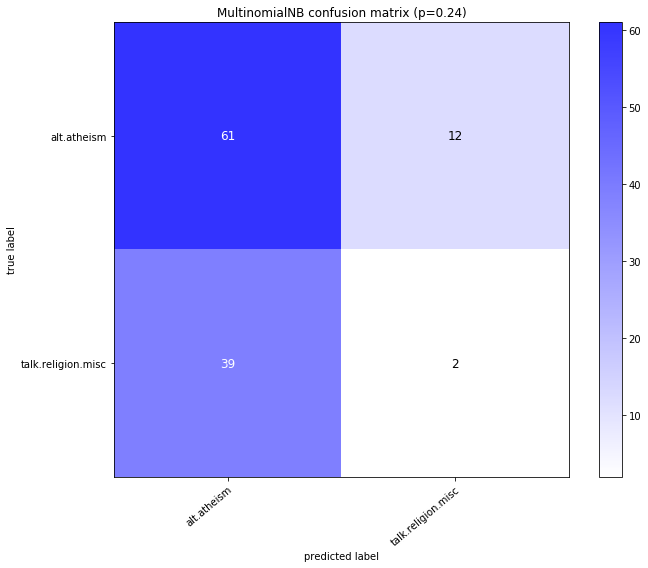

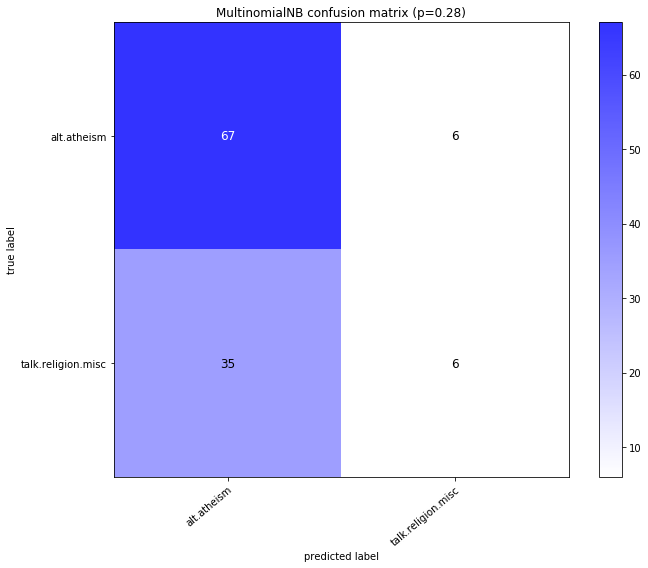

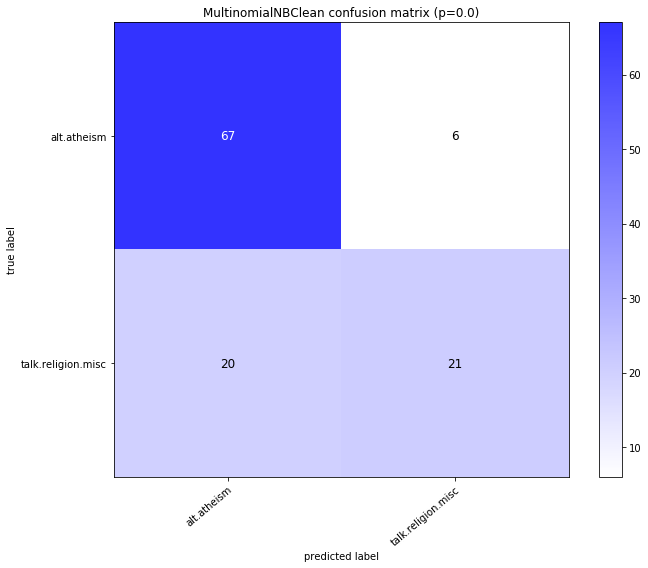

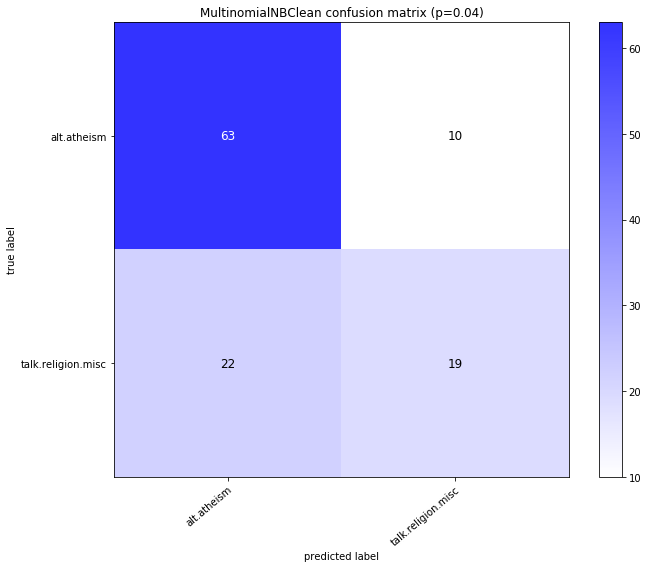

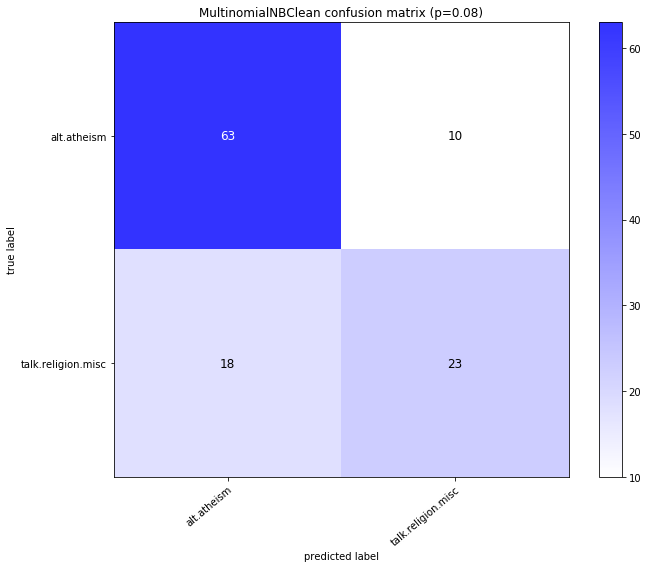

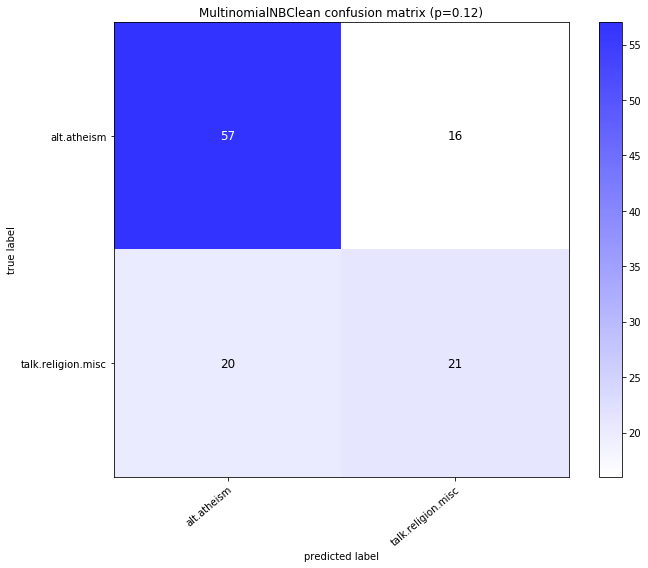

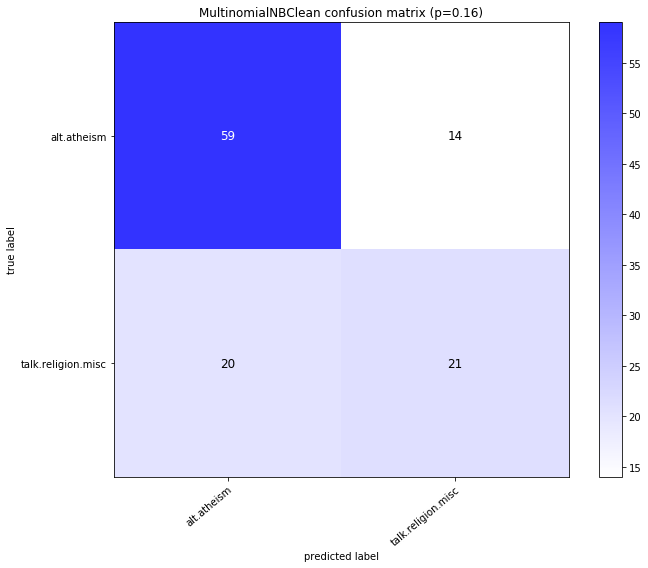

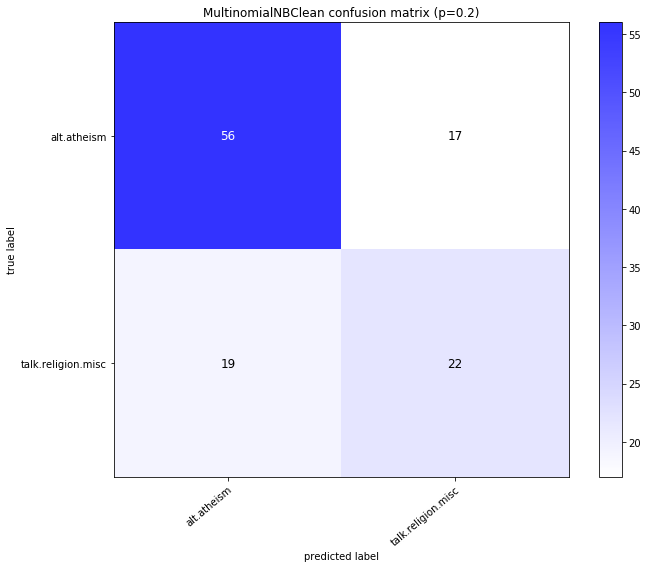

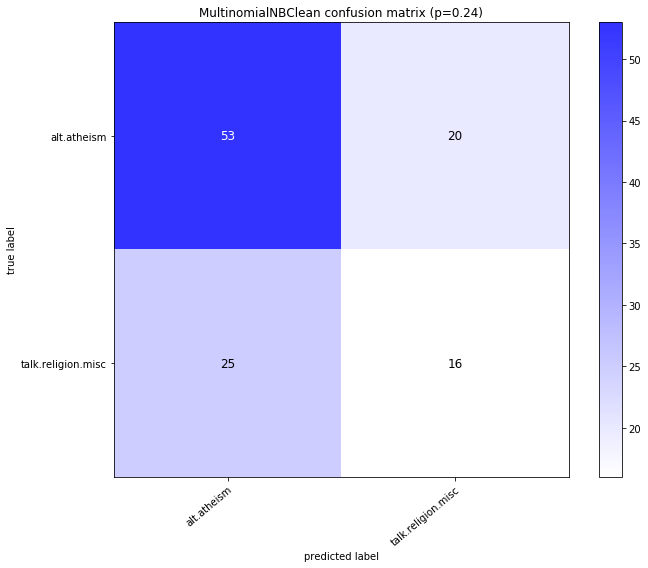

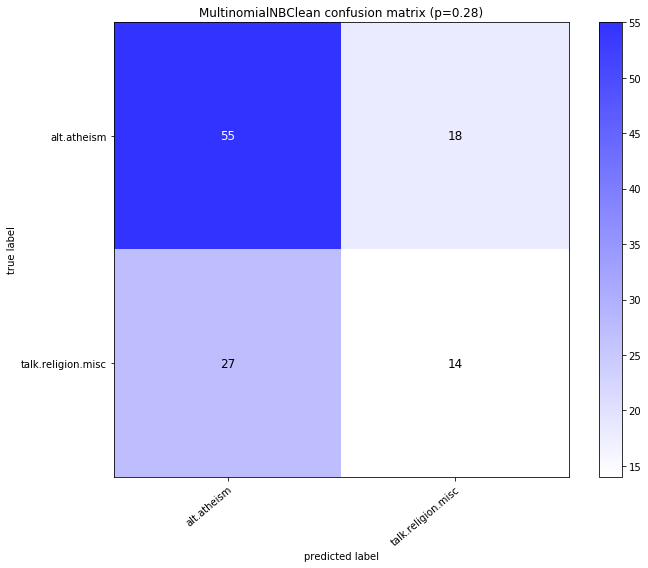

In [9]:
main(["a", "test", "2"])